In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [2]:
from scipy.constants import speed_of_light, elementary_charge, electron_mass, hbar

me_SI = electron_mass
hbar_SI = hbar   
e_SI = elementary_charge
c_SI = speed_of_light

meV = e_SI * 1e-3
nm = 1e-9
ps = 1e-12

c = c_SI * ps / nm           
hbar_meV_ps = hbar_SI / (meV * ps)  
me = me_SI * c_SI ** 2 / meV / c ** 2    

hbar = hbar_meV_ps
m = me
omega = 2 / hbar
vQD = 15

x0 = 0
x1 = 75
t0 = 0
t1 = 2
t2 = t1 + (x1 - x0) / vQD

x_min = -75
x_max = 150
t_min = 0
t_max = 20

In [3]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS backend for Apple GPU acceleration!")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using cuda")
else:
    device = torch.device("cpu")
    print("Using CPU instead.")

Using cuda


In [4]:
class PINN(nn.Module):
    def __init__(self, layers, t_min, t_max):
        super(PINN, self).__init__()
        self.hidden_layers = nn.ModuleList()
        
        for units in layers[1:-1]:
            self.hidden_layers.append(nn.Linear(in_features=layers[0], out_features=units))
            layers[0] = units
        
        self.output_layer = nn.Linear(layers[-2], layers[-1])

        self.n_collocation = 5000
        self.n_initial = 500
        self.n_boundary = 500

        self.t_min = t_min
        self.t_max = t_max
    
    def forward(self, inputs):
        x, t = inputs
        X = torch.stack((x, t), dim=1)
        activation_1 = nn.Tanh()
        activation_2 = nn.SiLU()
        i = 1
    
        for layer in self.hidden_layers:
            X = layer(X)
            X = activation_1(X) if i < 2 else activation_2(X)
            i += 1
    
        output = self.output_layer(X)
        psi_real = output[:, 0]
        psi_img = output[:, 1]
        
        return psi_real, psi_img

In [5]:
layers_1 = [2, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 2]
layers_2 = [2, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 2]
layers_3 = [2, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 2]

In [6]:
vanilla_model = PINN(layers_1, t_min, t_max)
causal_model = PINN(layers_2, t_min, t_max)
norm_model = PINN(layers_3, t_min, t_max)

In [7]:
vanilla_model.load_state_dict(torch.load("../results/general/model_4.pth", map_location=torch.device(device)))
causal_model.load_state_dict(torch.load("../results/causal/model_16.pth", map_location=torch.device(device)))
norm_model.load_state_dict(torch.load("../results/norm/model_31.pth", map_location=torch.device(device)))

<All keys matched successfully>

In [8]:
Nx = 5000
Nt = 5000

x_values = np.linspace(x_min, x_max, Nx)
t_values = np.linspace(t_min, t_max, Nt)

In [9]:
x_values_torch = torch.from_numpy(x_values).float()
t_values_torch = torch.from_numpy(t_values).float()

x_grid, t_grid = torch.meshgrid(x_values_torch, t_values_torch, indexing="ij")

x_flat = torch.reshape(x_grid, [-1])
t_flat = torch.reshape(t_grid, [-1])

batch_size = 1000000
psi_real_list_vanilla = []
psi_img_list_vanilla = []

psi_real_list_causal = []
psi_img_list_causal = []

psi_real_list_norm = []
psi_img_list_norm = []

vanilla_model.eval()
with torch.no_grad():
    for i in range(0, x_flat.shape[0], batch_size):
        x_batch = x_flat[i:i+batch_size]
        t_batch = t_flat[i:i+batch_size]
        psi_real, psi_img = vanilla_model((x_batch, t_batch))
        psi_real_list_vanilla.append(psi_real.cpu())
        psi_img_list_vanilla.append(psi_img.cpu())
        
print("1 / 3 rd over!")
        
causal_model.eval()
with torch.no_grad():
    for i in range(0, x_flat.shape[0], batch_size):
        x_batch = x_flat[i:i+batch_size]
        t_batch = t_flat[i:i+batch_size]
        psi_real, psi_img = causal_model((x_batch, t_batch))
        psi_real_list_causal.append(psi_real.cpu())
        psi_img_list_causal.append(psi_img.cpu())
        
print("2 / 3 rd over!")
        
norm_model.eval()
with torch.no_grad():
    for i in range(0, x_flat.shape[0], batch_size):
        x_batch = x_flat[i:i+batch_size]
        t_batch = t_flat[i:i+batch_size]
        psi_real, psi_img = norm_model((x_batch, t_batch))
        psi_real_list_norm.append(psi_real.cpu())
        psi_img_list_norm.append(psi_img.cpu())


psi_real_pinn_vanilla = torch.cat(psi_real_list_vanilla).reshape(Nx, Nt).numpy()
psi_img_pinn_vanilla = torch.cat(psi_img_list_vanilla).reshape(Nx, Nt).numpy()

psi_real_pinn_causal = torch.cat(psi_real_list_causal).reshape(Nx, Nt).numpy()
psi_img_pinn_causal = torch.cat(psi_img_list_causal).reshape(Nx, Nt).numpy()

psi_real_pinn_norm = torch.cat(psi_real_list_norm).reshape(Nx, Nt).numpy()
psi_img_pinn_norm = torch.cat(psi_img_list_norm).reshape(Nx, Nt).numpy()

1 / 3 rd over!
2 / 3 rd over!


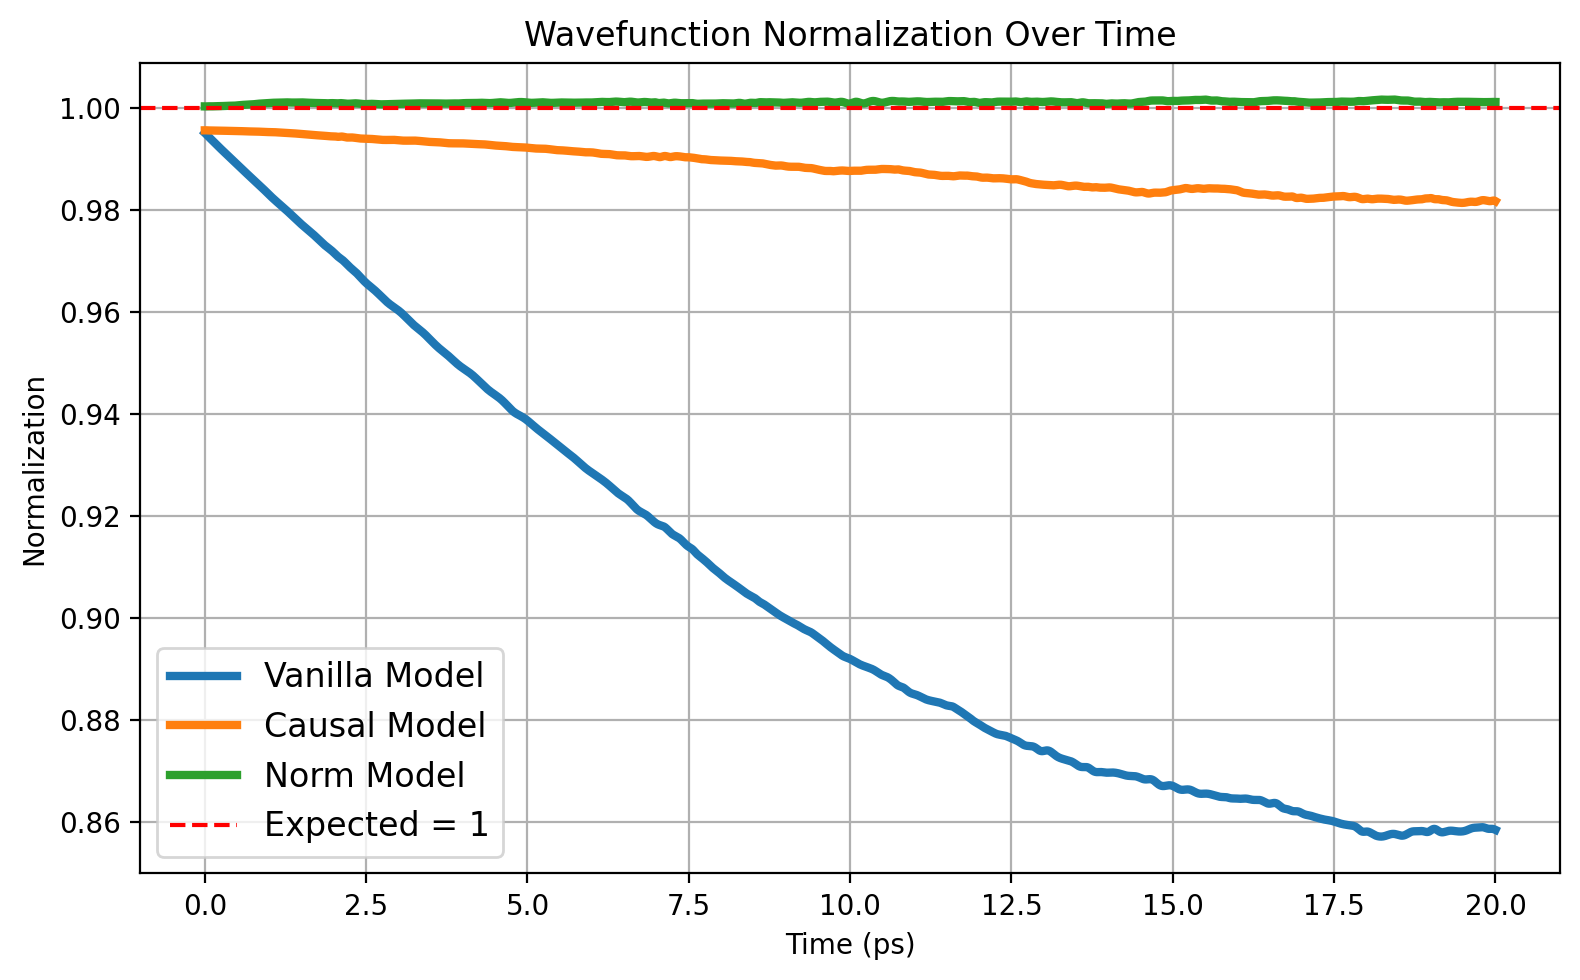

In [14]:
from scipy.integrate import simpson

norms_vanilla = []
norms_causal = []
norms_norm = []

for i in range(5000):
    psi_sq_i_vanilla = psi_real_pinn_vanilla[:, i] ** 2 + psi_img_pinn_vanilla[:, i] ** 2
    psi_sq_i_causal = psi_real_pinn_causal[:, i] ** 2 + psi_img_pinn_causal[:, i] ** 2
    psi_sq_i_norm = psi_real_pinn_norm[:, i] ** 2 + psi_img_pinn_norm[:, i] ** 2
    
    normalization_vanilla = simpson(psi_sq_i_vanilla, x=x_values)
    normalization_causal = simpson(psi_sq_i_causal, x=x_values)
    normalization_norm = simpson(psi_sq_i_norm, x=x_values)
    
    norms_vanilla.append(normalization_vanilla)
    norms_causal.append(normalization_causal)
    norms_norm.append(normalization_norm)

fig, ax = plt.subplots(figsize=(8, 5), dpi=200)

ax.plot(t_values, norms_vanilla, '-', label='Vanilla Model', linewidth=3)
ax.plot(t_values, norms_causal, '-', label='Causal Model', linewidth=3)
ax.plot(t_values, norms_norm, '-', label='Norm Model', linewidth=3)

ax.axhline(1.0, color='red', linestyle='--', label='Expected = 1')

ax.yaxis.get_major_formatter().set_useOffset(False)

ax.set_xlabel('Time (ps)')
ax.set_ylabel('Normalization')
ax.set_title('Wavefunction Normalization Over Time')
ax.legend(fontsize=12)
ax.grid(True)

plt.tight_layout()
plt.show()